<a href="https://colab.research.google.com/github/Rebe1Coding/bigData/blob/main/heartpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/heart-failure-prediction


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [31]:
df = pd.read_csv(path + "/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [32]:
def translate_dataset(df):
    df = df.copy()

    # Переименовываем столбцы
    column_translation = {
        'Age': 'Возраст',
        'Sex': 'Пол',
        'ChestPainType': 'Тип_боли_в_груди',
        'RestingBP': 'Давление_покоя',
        'Cholesterol': 'Холестерин',
        'FastingBS': 'Сахар_крови_натощак',
        'RestingECG': 'ЭКГ_покоя',
        'MaxHR': 'Макс_ЧСС',
        'ExerciseAngina': 'Стенокардия_нагрузки',
        'Oldpeak': 'Депрессия_ST',
        'ST_Slope': 'Наклон_ST',
        'HeartDisease': 'Болезнь_сердца'
    }
    df = df.rename(columns=column_translation)

    # Функция для безопасного перевода значений
    def safe_map(series, mapping_dict, default_val=None):
        return series.map(mapping_dict).fillna(series if default_val is None else default_val)

    # Переводим значения в категориальных столбцах
    if 'Пол' in df.columns:
        df['Пол'] = safe_map(df['Пол'], {'M': 'Мужской', 'F': 'Женский'}, 'Неизвестно')

    if 'Тип_боли_в_груди' in df.columns:
        df['Тип_боли_в_груди'] = safe_map(df['Тип_боли_в_груди'], {
            'TA': 'Типичная_стенокардия',
            'ATA': 'Атипичная_стенокардия',
            'NAP': 'Неангинальная_боль',
            'ASY': 'Бессимптомно'
        }, 'Неизвестно')

    if 'ЭКГ_покоя' in df.columns:
        df['ЭКГ_покоя'] = safe_map(df['ЭКГ_покоя'], {
            'Normal': 'Норма',
            'ST': 'ST-T_аномалия',
            'LVH': 'Гипертрофия_левого_желудочка'
        }, 'Неизвестно')

    if 'Стенокардия_нагрузки' in df.columns:
        df['Стенокардия_нагрузки'] = safe_map(df['Стенокардия_нагрузки'], {
            'Y': 'Да',
            'N': 'Нет'
        }, 'Неизвестно')

    if 'Наклон_ST' in df.columns:
        df['Наклон_ST'] = safe_map(df['Наклон_ST'], {
            'Up': 'Восходящий',
            'Flat': 'Плоский',
            'Down': 'Нисходящий'
        }, 'Неизвестно')

    if 'Болезнь_сердца' in df.columns:
        df['Болезнь_сердца'] = safe_map(df['Болезнь_сердца'], {
            1: 'Да',
            0: 'Нет'
        }, 'Неизвестно')

    return df


In [33]:
df = translate_dataset(df)
df.head()

,Возраст,Пол,Тип_боли_в_груди,Давление_покоя,Холестерин,Сахар_крови_натощак,ЭКГ_покоя,Макс_ЧСС,Стенокардия_нагрузки,Депрессия_ST,Наклон_ST,Болезнь_сердца
0,40,Мужской,Атипичная_стенокардия,140,289,0,Норма,172,Нет,0.0,Восходящий,Нет
1,49,Женский,Неангинальная_боль,160,180,0,Норма,156,Нет,1.0,Плоский,Да
2,37,Мужской,Атипичная_стенокардия,130,283,0,ST-T_аномалия,98,Нет,0.0,Восходящий,Нет
3,48,Женский,Бессимптомно,138,214,0,Норма,108,Да,1.5,Плоский,Да
4,54,Мужской,Неангинальная_боль,150,195,0,Норма,122,Нет,0.0,Восходящий,Нет


In [34]:
df.isnull().sum()

,0
Возраст,0
Пол,0
Тип_боли_в_груди,0
Давление_покоя,0
Холестерин,0
Сахар_крови_натощак,0
ЭКГ_покоя,0
Макс_ЧСС,0
Стенокардия_нагрузки,0
Депрессия_ST,0


In [35]:
num_col = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] ]
num_col

['Возраст',
 'Давление_покоя',
 'Холестерин',
 'Сахар_крови_натощак',
 'Макс_ЧСС',
 'Депрессия_ST']

In [36]:
cat_col = [col for col in df.columns if df[col].dtype == 'object']
cat_col

['Пол',
 'Тип_боли_в_груди',
 'ЭКГ_покоя',
 'Стенокардия_нагрузки',
 'Наклон_ST',
 'Болезнь_сердца']

<Axes: >

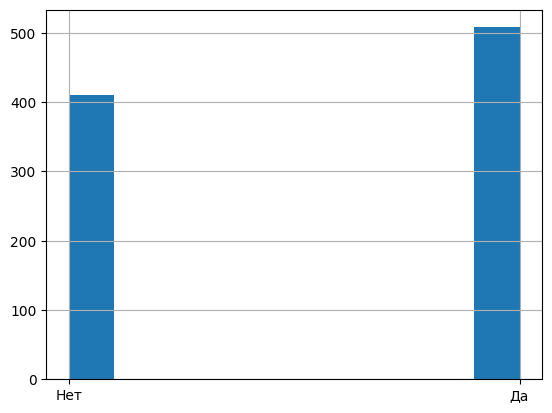

In [48]:
df['Болезнь_сердца'].hist()

In [65]:
encoder = LabelEncoder()
for col in cat_col:
  df[col] = encoder.fit_transform(df[col])

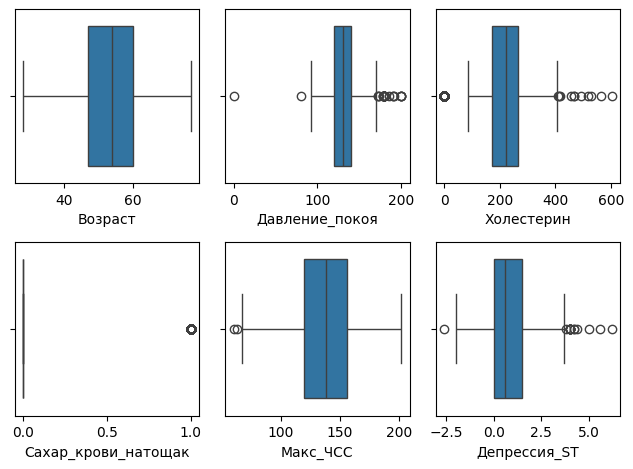

In [37]:
col = 3
row = math.ceil(len(num_col) / col)
fig, axes = plt.subplots(row, col)
ax = axes.flatten()
for i,col in enumerate(num_col):
  sns.boxplot(x=df[col], ax = ax[i])
plt.tight_layout()
plt.show()

In [38]:
df.shape

(918, 12)

<Axes: >

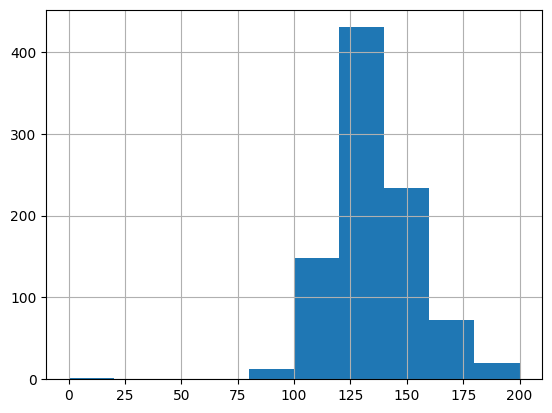

In [39]:
df['Давление_покоя'].hist()

In [40]:
for col in ['Давление_покоя','Холестерин','Макс_ЧСС']:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q3 - 1.5 * IQR
  upper_bound = Q1 + 1.5 * IQR
  mean_value = df[col].mean()
  df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), mean_value, df[col])

<Axes: xlabel='Макс_ЧСС'>

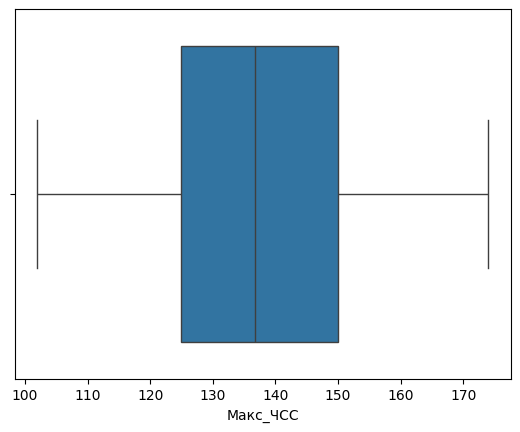

In [43]:
sns.boxplot(x=df['Макс_ЧСС'])

<Axes: >

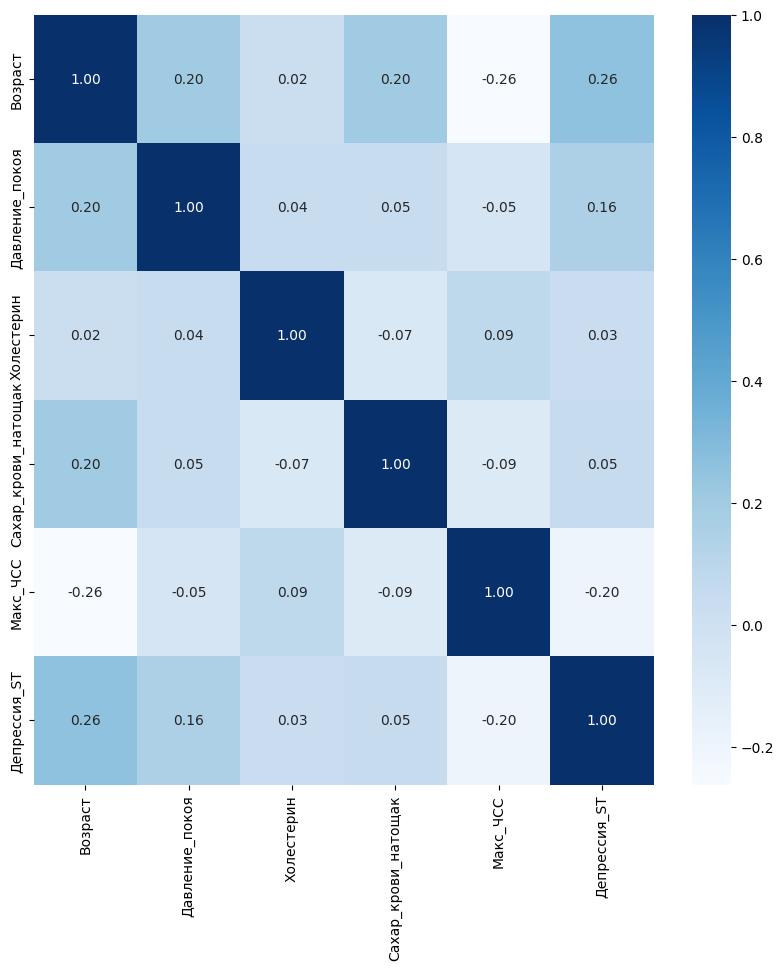

In [45]:
matrix_corr = df[num_col].corr()

plt.figure(figsize=(10,10))
sns.heatmap(matrix_corr, annot=True, cmap='Blues', fmt='.2f')

In [51]:
df[num_col].corrwith(df['Болезнь_сердца']).sort_values(ascending=False)

,0
Макс_ЧСС,0.328682
Холестерин,0.035027
Давление_покоя,-0.059925
Сахар_крови_натощак,-0.267291
Возраст,-0.282039
Депрессия_ST,-0.403951


<Axes: >

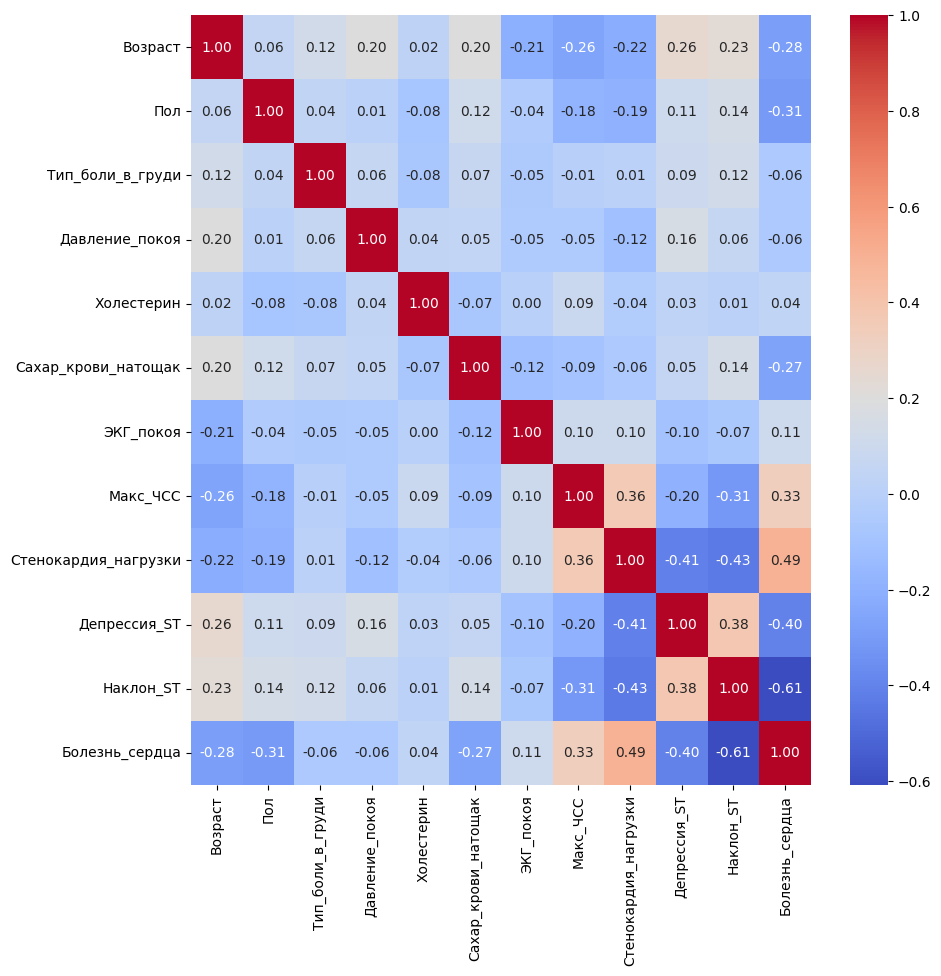

In [52]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')

In [67]:
for col in df.columns:
  if col != 'Болезнь_сердца':
    df[col]= StandardScaler().fit_transform(df[col].values.reshape(-1,1))

In [66]:
X = df.drop('Болезнь_сердца',axis=1)
y = df['Болезнь_сердца']
y

,Болезнь_сердца
0,1
1,0
2,1
3,0
4,1
...,...
913,0
914,0
915,0
916,0


In [68]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [69]:
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [71]:
y_pred= model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
con_mat = confusion_matrix(y_test,y_pred)
class_rep = classification_report(y_test,y_pred)
print(f"Точность модели: {accuracy:.2f}")
print(con_mat)
print(class_rep)

Точность модели: 0.83
[[107  25]
 [ 14  84]]
              precision    recall  f1-score   support

           0       0.88      0.81      0.85       132
           1       0.77      0.86      0.81        98

    accuracy                           0.83       230
   macro avg       0.83      0.83      0.83       230
weighted avg       0.84      0.83      0.83       230

